# *Etapa 4: Processamento dos dados*

Neste notebook, realizamos a junção das principais bases. São elas:

- ``df_offers``: informações das ofertas
- ``df_profile``: informações dos clientes
- ``df_client_transactions``: informações das transações
- ``transactions_received``: informações dos eventos de ofertas recebidas
- ``transactions_viewed``: informações dos eventos de ofertas visualizadas
- ``transactions_completed``: informações dos eventos de ofertas concluidas

Ao término do processamento, devemos ter as seguintes variáveis:

## mastertable
* ``client_id``: código de identificação do cliente
* ``offer_id``:  id da oferta
* ``time_received``: tempo desde o começo do teste em dias (t=0)
* ``qtd_offer_received``: quantidade de ofertas recebidas
* ``time_viewed``: tempo desde o começo do teste em dias (t=0)
* ``qtd_offer_viewed``: quantidade de ofertas visualizadas
* ``time_completed``: tempo desde o começo do teste em dias (t=0)
* ``qtd_offer_completed``: quantidade de ofertas completadas
* ``sum_reward``: desconto
* ``registered_on``: data de criação da conta
* ``registered_duration_days``: tempo de relacionamento em dias
* ``registered_duration_month``: tempo de relacionamento em meses
* ``registered_duration_years``: tempo de relacionamento em anos
* ``gender``: gênero do cliente
* ``gender_M``: variável dummy para indicar o gênero masculino 'M'
* ``gender_F``: variável dummy para indicar o gênero feminino 'F'
* ``gender_O``: variável dummy para indicar o gênero outros 'O'
* ``gender_U``: variável dummy para indicar o gênero desconhecido 'U'
* ``age``: idade do cliente na criação da conta
* ``age_group``: grupo de idades de 10 em 10 anos
* ``age_group_index``: identificador para o grupo de idade
* ``credit_card_limit``: limite do cartão registrado
* ``category_limite``: indicador de renda do cliente (1=renda menor, 5=renda maior)
* ``offer_type``: o tipo da oferta (BOGO, discount, informational)
* ``offer_min_value``: valor mínimo para ativação da oferta
* ``offer_discount_value``: valor do desconto da oferta
* ``offer_duration``: duração da oferta
* ``channel_mobile``: variável dummy para indicar a veiculação da oferta em 'mobile'
* ``channel_email``: variável dummy para indicar a veiculação da oferta em 'email'
* ``channel_social``: variável dummy para indicar a veiculação da oferta em 'social'
* ``channel_web``: variável dummy para indicar a veiculação da oferta em 'web'
* ``offer_type_index``: um código para o tipo de oferta
* ``time_transaction``: tempo desde o começo do teste em dias (t=0)
* ``qtd_transaction``: quantidade de transações
* ``total_amount``: valor da transação
* ``avg_amount``: valor médio do valor da transação

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PySparkTest').getOrCreate()

from IPython.display import display, HTML
display(HTML("<style>.jp-Cell-outputArea { text-align: center; }</style>"))

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/12 11:20:33 WARN Utils: Your hostname, N0L144853, resolves to a loopback address: 127.0.1.1; using 192.168.68.112 instead (on interface enp0s31f6)
25/08/12 11:20:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/12 11:20:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import plotly.express as px
from pyspark.sql import types as T
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Read Files

In [3]:
path_output_mastertable = '../data/trusted/mastertable'

path_table_offers = "../data/trusted/offers"
path_table_profile = "../data/trusted/profile"

path_client_transactions = "../data/trusted/client_transactions"
path_transactions_received = "../data/trusted/transactions_received"
path_transactions_viewed = "../data/trusted/transactions_viewed"
path_transactions_completed = "../data/trusted/transactions_completed"


df_offers = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_table_offers)
df_profile = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_table_profile)

df_client_transactions = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_client_transactions)
transactions_received = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_transactions_received)
transactions_viewed = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_transactions_viewed)
transactions_completed = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_transactions_completed)

# Data Merge

##### Juntando tabela de eventos

In [4]:
df = transactions_received.join(transactions_viewed, on=['client_id','offer_id'], how='left')\
                          .join(transactions_completed, on=['client_id','offer_id'], how='left')\
                          .fillna({'qtd_offer_completed': 0, 'qtd_offer_viewed': 0, 'sum_reward': 0})\
                          .withColumn("time_viewed", F.coalesce(F.col("time_viewed"), F.array().cast(T.ArrayType(T.DoubleType()))))\
                          .withColumn("time_completed", F.coalesce(F.col("time_completed"), F.array().cast(T.ArrayType(T.DoubleType()))))\
                          .orderBy('client_id','offer_id')

df.show(5, truncate=False)

+--------------------------------+--------------------------------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+
|client_id                       |offer_id                        |time_received|qtd_offer_received|time_viewed|qtd_offer_viewed|time_completed|qtd_offer_completed|sum_reward|
+--------------------------------+--------------------------------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+
|0009655768c64bdeb2e877511632db8f|2906b810c7d4411798c6938adc9daaa5|[24.0]       |1                 |[]         |0               |[24.0]        |1                  |2.0       |
|0009655768c64bdeb2e877511632db8f|3f207df678b143eea3cee63160fa8bed|[14.0]       |1                 |[15.5]     |1               |[]            |0                  |0.0       |
|0009655768c64bdeb2e877511632db8f|5a8bc65990b245e5a138643cd4eb9837|[7.0]        |1                 |[8.0]      |1       

In [5]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+
|client_id|offer_id|time_received|qtd_offer_received|time_viewed|qtd_offer_viewed|time_completed|qtd_offer_completed|sum_reward|
+---------+--------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+
|        0|       0|            0|                 0|          0|               0|             0|                  0|         0|
+---------+--------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+



In [6]:
df.groupBy("qtd_offer_completed").count().show()

+-------------------+-----+
|qtd_offer_completed|count|
+-------------------+-----+
|                  0|34292|
|                  1|24793|
|                  3|  342|
|                  2| 3842|
|                  4|   19|
+-------------------+-----+



##### Juntando com dados das ofertas, dos clientes e transações dos clientes

In [7]:
df_merge = df.join(df_profile, on="client_id", how="left")\
             .join(df_offers, on="offer_id", how="left")\
             .join(df_client_transactions, on="client_id", how="left")\
             .fillna({'qtd_transaction': 0, 'total_amount': 0, 'avg_amount': 0})\
             .withColumn("time_transaction", F.coalesce(F.col("time_transaction"), F.array().cast(T.ArrayType(T.DoubleType()))))

df_merge.show(5, truncate=False)

25/08/12 11:20:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------------------+--------------------------------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+-------------+------------------------+-------------------------+-------------------------+------+--------+--------+--------+--------+---+---------+---------------+-----------------+---------------+-------------+---------------+--------------------+--------------+--------------+-------------+--------------+-----------+----------------+-------------------------------------------------+---------------+------------+----------+
|client_id                       |offer_id                        |time_received|qtd_offer_received|time_viewed|qtd_offer_viewed|time_completed|qtd_offer_completed|sum_reward|registered_on|registered_duration_days|registered_duration_month|registered_duration_years|gender|gender_M|gender_F|gender_O|gender_U|age|age_group|age_group_index|credit_card_limit|category_limite|offer_type   |offer_min_

In [8]:
df_merge.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_merge.columns]).show()

+---------+--------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+-------------+------------------------+-------------------------+-------------------------+------+--------+--------+--------+--------+---+---------+---------------+-----------------+---------------+----------+---------------+--------------------+--------------+--------------+-------------+--------------+-----------+----------------+----------------+---------------+------------+----------+
|client_id|offer_id|time_received|qtd_offer_received|time_viewed|qtd_offer_viewed|time_completed|qtd_offer_completed|sum_reward|registered_on|registered_duration_days|registered_duration_month|registered_duration_years|gender|gender_M|gender_F|gender_O|gender_U|age|age_group|age_group_index|credit_card_limit|category_limite|offer_type|offer_min_value|offer_discount_value|offer_duration|channel_mobile|channel_email|channel_social|channel_web|offer_type_index|time_transaction|q

In [9]:
df_merge.write.format("parquet").mode("overwrite").save(path_output_mastertable)

# Analysis

In [10]:
df_merge_analysis = df_merge.select("client_id", 'offer_id', 'qtd_offer_received', 'qtd_offer_completed', 'offer_type', 'gender', 'age', 'age_group', 'age_group_index', 'category_limite')  
df_merge_analysis.show(5, truncate=False)

+--------------------------------+--------------------------------+------------------+-------------------+-------------+------+---+---------+---------------+---------------+
|client_id                       |offer_id                        |qtd_offer_received|qtd_offer_completed|offer_type   |gender|age|age_group|age_group_index|category_limite|
+--------------------------------+--------------------------------+------------------+-------------------+-------------+------+---+---------+---------------+---------------+
|0009655768c64bdeb2e877511632db8f|2906b810c7d4411798c6938adc9daaa5|1                 |1                  |discount     |M     |33 |30-39    |2              |3              |
|0009655768c64bdeb2e877511632db8f|3f207df678b143eea3cee63160fa8bed|1                 |0                  |informational|M     |33 |30-39    |2              |3              |
|0009655768c64bdeb2e877511632db8f|5a8bc65990b245e5a138643cd4eb9837|1                 |0                  |informational|M     |33 

##### Analisando Taxa de Conversao de ofertas por Faixa Etaria e Tipo de Oferta

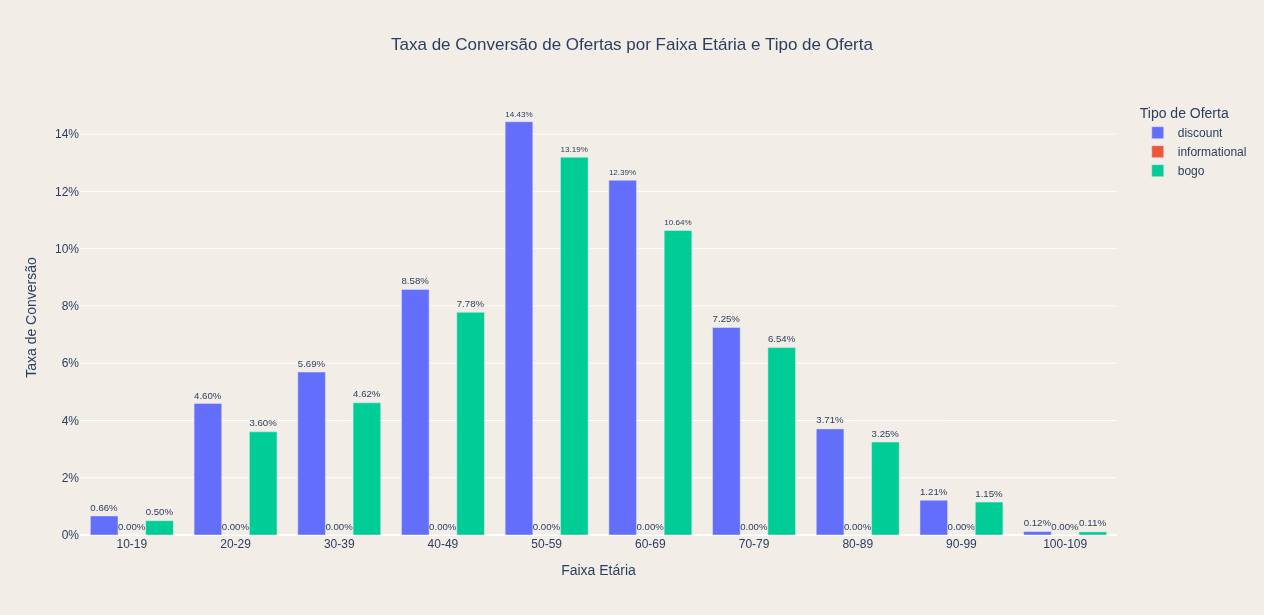

In [11]:
fig = px.bar(
    df_merge_analysis.groupBy('age_group', 'age_group_index', 'offer_type').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed'))\
                     .join(df_merge_analysis.groupBy('offer_type').agg(F.sum('qtd_offer_received').alias('total_ofertas')), on='offer_type', how='inner')\
                     .withColumn('rate_convertion', F.col('qtd_offer_completed')/F.col('total_ofertas'))\
                     .orderBy('age_group_index').toPandas(),
    x="age_group",
    y="rate_convertion",
    color="offer_type",
    barmode="group",
    text="rate_convertion",
    labels={
        "age_group": "Faixa Etária",
        "rate_convertion": "Taxa de Conversão",
        "offer_type": "Tipo de Oferta"
    },
    title="Taxa de Conversão de Ofertas por Faixa Etária e Tipo de Oferta"
)
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=600,
    width=1600,
    plot_bgcolor="#f2ede6",  
    paper_bgcolor="#f2ede6",
    yaxis_tickformat=".0%"
)

fig.show()

##### Analisando Ofertas completadaspor Tipo de Oferta

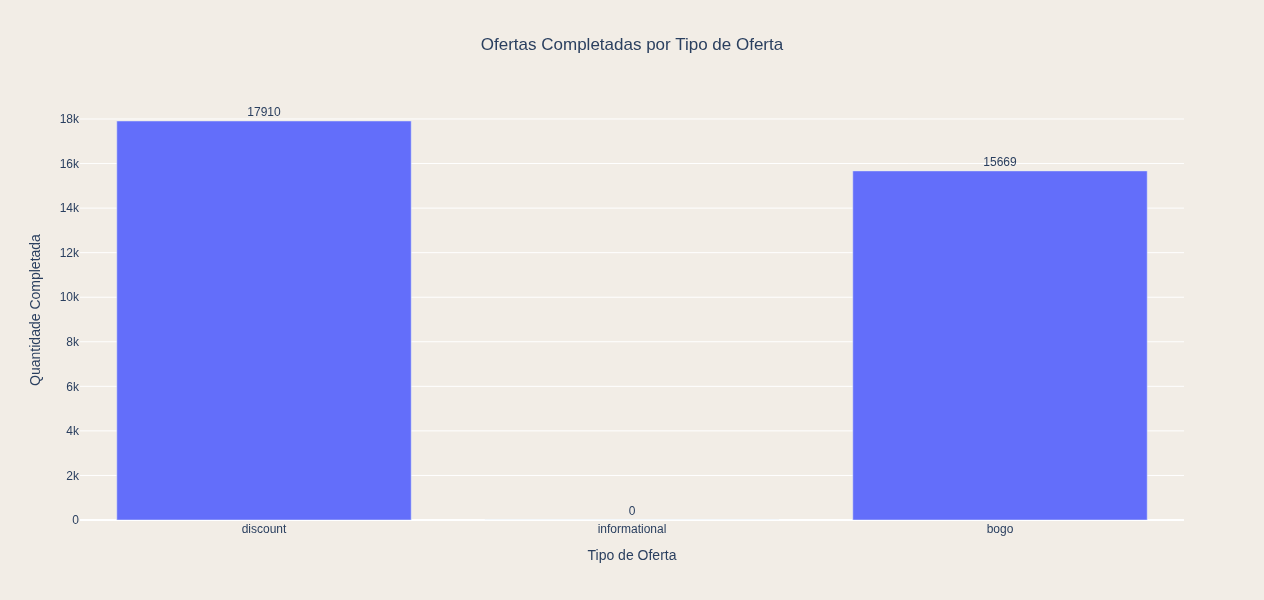

In [12]:
fig = px.bar(
    df_merge_analysis.groupBy('offer_type').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed')).toPandas(),
    x="offer_type",
    y="qtd_offer_completed",
    text="qtd_offer_completed",
    title="Ofertas Completadas por Tipo de Oferta",
    labels={"offer_type": "Tipo de Oferta", "qtd_offer_completed": "Quantidade Completada"},
)

fig.update_traces(textposition='outside')

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=600,
    width=800,
    plot_bgcolor="#f2ede6",  
    paper_bgcolor="#f2ede6",
)
fig.show()

##### Analisando Ofertas completadas por Faixa Etaroa e Renda

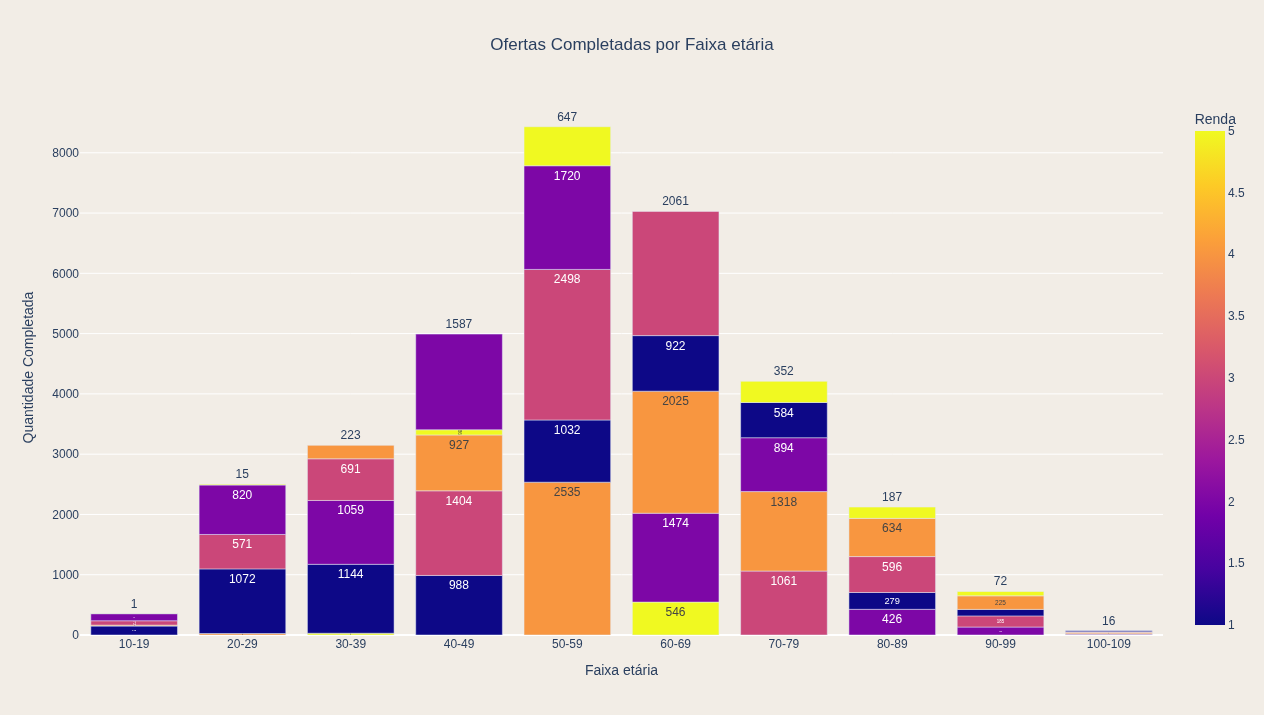

In [13]:
fig = px.bar(
    df_merge_analysis.groupBy('age_group', 'age_group_index', 'category_limite').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed'))\
                     .orderBy('age_group_index').toPandas(),
    x="age_group",
    y="qtd_offer_completed",
    color="category_limite",
    text="qtd_offer_completed",
    title="Ofertas Completadas por Faixa etária",
    labels={"age_group": "Faixa etária", "qtd_offer_completed": "Quantidade Completada", 'category_limite': "Renda"},
)

fig.update_traces(textposition='outside')

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=700,
    width=1800,
    plot_bgcolor="#f2ede6",  
    paper_bgcolor="#f2ede6",
)


fig.show()


##### Analisando Ofertas completadas por Genero

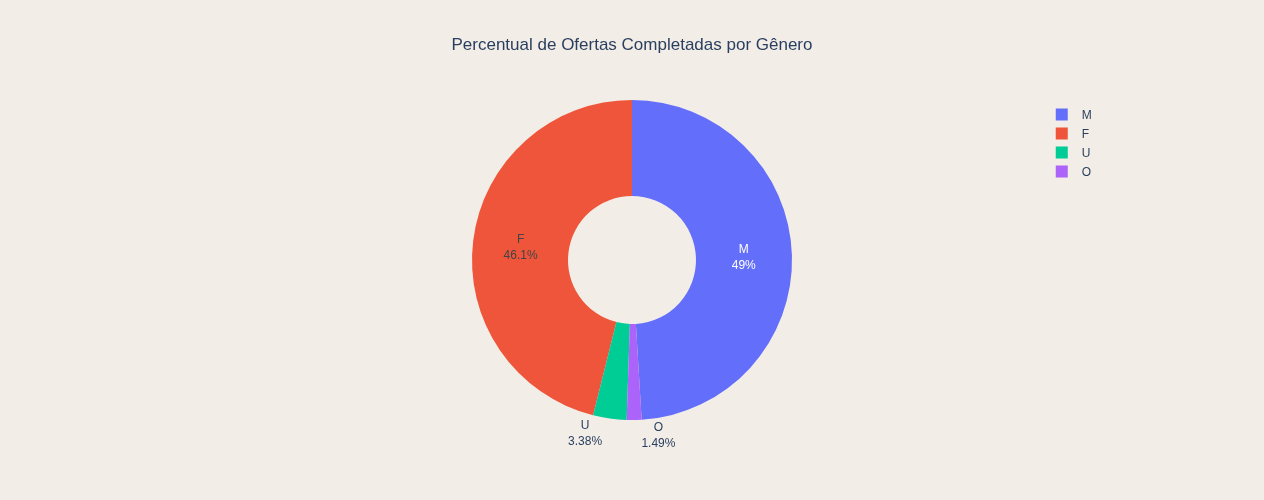

In [14]:
fig = px.pie(
    df_merge_analysis.groupBy('gender').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed')).orderBy('gender').toPandas(),
    names="gender",
    values="qtd_offer_completed",
    title="Percentual de Ofertas Completadas por Gênero",
    hole=0.4  
)

fig.update_traces(textinfo='percent+label')

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=500,
    width=800,
    plot_bgcolor="#f2ede6",  
    paper_bgcolor="#f2ede6",
)
fig.show()

##### Analisando Ofertas completadas por Renda

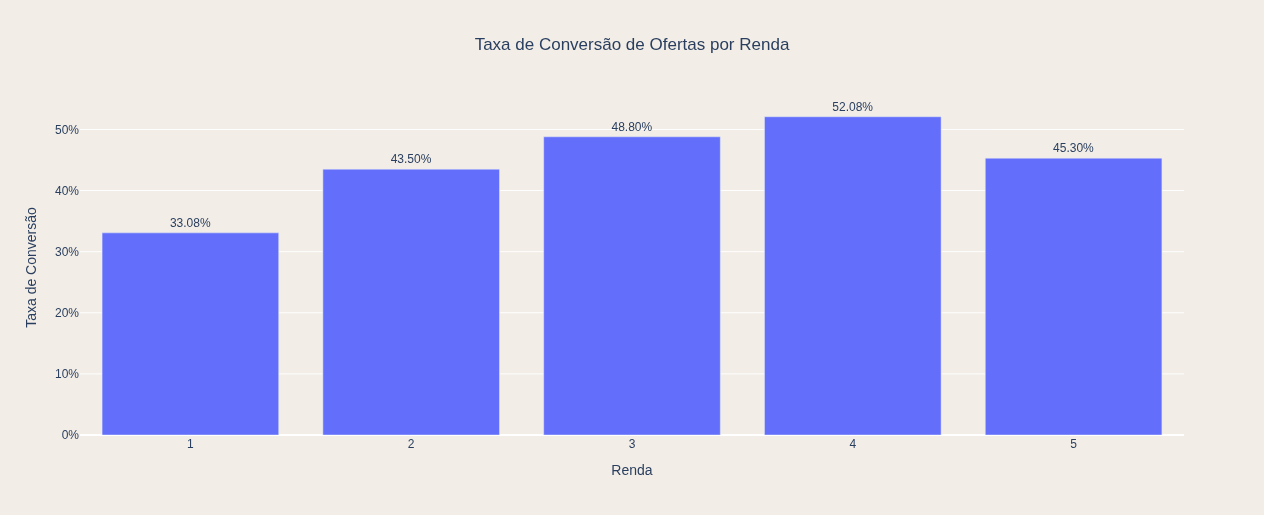

In [15]:
fig = px.bar(
    df_merge_analysis.groupBy('category_limite').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed'), 
                                                     F.sum('qtd_offer_received').alias('total_ofertas'))\
        .withColumn('rate_convertion', F.col('qtd_offer_completed')/F.col('total_ofertas'))\
        .orderBy('category_limite').toPandas(),
    x="category_limite",
    y="rate_convertion",
    text="rate_convertion",
    title="Taxa de Conversão de Ofertas por Renda",
    labels={"category_limite": "Renda", "rate_convertion": "Taxa de Conversão"},
)

fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=500,
    width=1500,
    plot_bgcolor="#f2ede6",  
    paper_bgcolor="#f2ede6",
    yaxis_tickformat=".0%"
)

fig.show()

### Considerações

 - Descontos são mais procurados que ofertas rápidas
    - Descontos são eficazes em clientes entre 40 e 60 anos
 - Ofertas informativas não tiveram nenhuma conclusão
    - Os dados nos mostram que não vale a pena manter do jeito que está
 - Clientes mais velhos e mais ricos procuram mais ofertas que pessoas mais novas
 - Sugestão: Melhorar Ofertas para pessoas mais Jovens e de Baixa Renda
 - Interessante: Todos os Grupos de Idades têm representação de renda.
 - Features que fazem total mudança: Faixa Etária, Renda, Tipo da Oferta
